In [65]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
import numpy as np

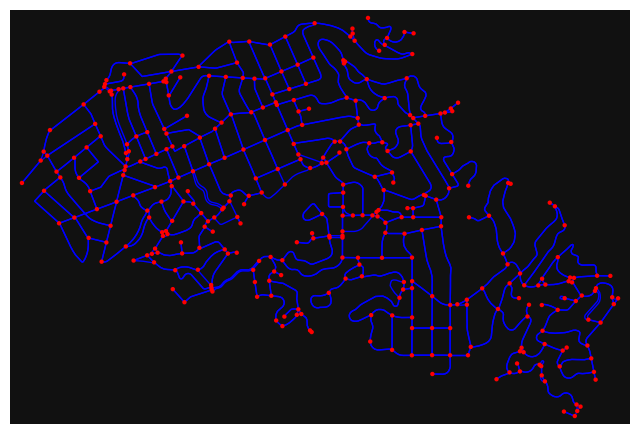

In [82]:
# Get a street network from OpenStreetMap for Sivas, Turkey
place_name = "Piedmont, California, USA"
G = ox.graph_from_place(place_name, network_type='drive')

# Convert to a networkx graph and visualize it
G = nx.convert_node_labels_to_integers(G)
fig, ax = ox.plot_graph(G, node_size=10, node_color='r', edge_color='b')

# Extract node features and edges
nodes = list(G.nodes)
edges = list(G.edges)
x_coords = np.array([G.nodes[node]['x'] for node in nodes])
y_coords = np.array([G.nodes[node]['y'] for node in nodes])

# Normalize coordinates
x_coords = (x_coords - x_coords.mean()) / x_coords.std()
y_coords = (y_coords - y_coords.mean()) / y_coords.std()

# Create feature tensor (including both x and y coordinates)
features = np.vstack((x_coords, y_coords)).T
x = torch.tensor(features, dtype=torch.float)

# Convert edges to tensor
edge_index = torch.tensor([[e[0], e[1]] for e in edges], dtype=torch.long).t().contiguous()

# Create a PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

In [83]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(2, 16, heads=4, concat=True, dropout=0.2)
        self.conv2 = GATConv(64, 2, heads=1, concat=True, dropout=0.2)  # Predicting 2D coordinates

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.sigmoid(x)
        x = torch.dropout(x, p=0.2, train=self.training)
        x = self.conv2(x, edge_index)
        return x

# Instantiate the model, define the optimizer and loss function (Manhattan distance)
model = GAT()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

# Train the model
model.train()
for epoch in range(500):  # Increase number of epochs
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, x)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 1.3293534517288208
Epoch 50, Loss: 0.22379475831985474
Epoch 100, Loss: 0.17352554202079773
Epoch 150, Loss: 0.1347372829914093
Epoch 200, Loss: 0.13966597616672516
Epoch 250, Loss: 0.13745735585689545
Epoch 300, Loss: 0.13719122111797333
Epoch 350, Loss: 0.12869630753993988
Epoch 400, Loss: 0.11474394053220749
Epoch 450, Loss: 0.1121695265173912


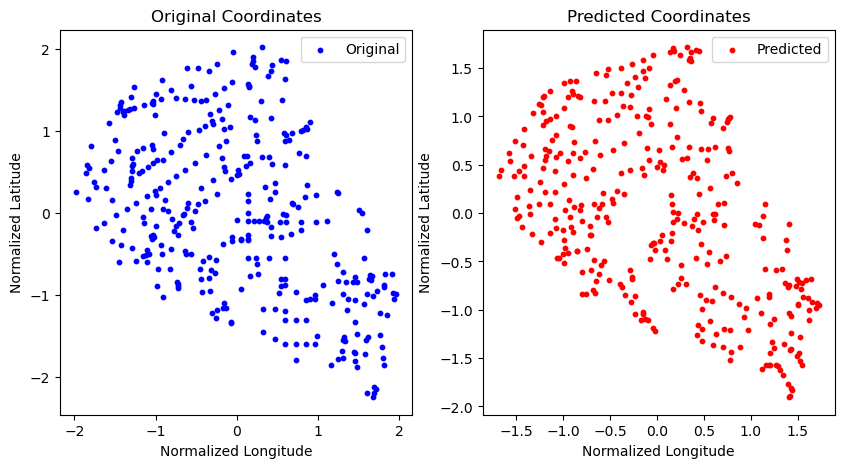

In [84]:
# Evaluate the model
model.eval()
out = model(data)
predicted_coords = out.detach().numpy()

# Plot the original and predicted coordinates
plt.figure(figsize=(10, 5))

# Original coordinates
plt.subplot(1, 2, 1)
plt.scatter(features[:, 0], features[:, 1], s=10, c='blue', label='Original')
plt.title('Original Coordinates')
plt.xlabel('Normalized Longitude')
plt.ylabel('Normalized Latitude')
plt.legend()

# Predicted coordinates
plt.subplot(1, 2, 2)
plt.scatter(predicted_coords[:, 0], predicted_coords[:, 1], s=10, c='red', label='Predicted')
plt.title('Predicted Coordinates')
plt.xlabel('Normalized Longitude')
plt.ylabel('Normalized Latitude')
plt.legend()

plt.show()